# Python & SQL: wind power potential

**Authors:** Grace Kumaishi and Julia Parish

**Date:** 2021-12-03

## Table of Contents

[1. Land Suitability](#land)<br>
[2. Area Suitability](#area)<br>
[3. Total Potential Wind Turbines](#turbines)<br>
[4. Total Wind Energy Production](#energy)<br>
[5. Results](#results)<br>
[6. References](#references)


### Import Python Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import gpxpy
import numpy
import sqlalchemy
import psycopg2
import math

Connect to Postgres database.

In [2]:
pg_uri_template = 'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'
db_uri = pg_uri_template.format(
    host="128.111.89.111",
    user="eds223_students",
    pwd="***********",
    db_name="osmiowa"
)

In [3]:
db = sqlalchemy.create_engine(db_uri)

Read in all data.

In [4]:
osm_polygon = gpd.read_postgis('SELECT * FROM planet_osm_polygon', con = db, geom_col = 'way')

osm_line = gpd.read_postgis('SELECT * FROM planet_osm_line', con = db, geom_col = 'way')

osm_point = gpd.read_postgis('SELECT * FROM planet_osm_point', con = db, geom_col = 'way')

<a id='land'></a> 

## 1.1 Land Suitability

Identify all land suitable for wind turbine placement, subject to the defined siting constraints.

**Siting constraints**

Wind turbines can only be sited in locations that satisfy all of these spatial constraints:

**Minimum distance to turbine**	| **Feature class**<br>
3 H	    -  residential buildings (scenario 1)<br>
10 H	- residential buildings (scenario 2)<br>
3 H	    - non-residential buildings<br>
7500 m	- airports<br>
0	    - military facilities<br>
2 H	    - highways and railroads<br>
0	    - nature reserves, parks, and wetlands<br>
1 H	    - rivers<br>
0	    - lakes<br>
2 H	    - power lines<br>
1 H	    - power plants<br>
5 d	    - wind turbines<br>

**NOTE:**<br>
0: turbine may be immediately adjacent to, but not on or in, the feature

In [5]:
# H = turbine height (tower base ↔ tip of vertical rotor)
H = 150

# d = rotor diameter
d = 136

# airport buffer
airport = 7500

### 1.1a. Residential 3H

In [6]:
# buffer residental buildings scenario 1

residential_3H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 3 * {H}) AS way
                                   FROM planet_osm_polygon
                                   WHERE building IN ('yes', 'house', 'apartments', 'residential', 'detached', 'cabin', 'semidetached_house', 'static_caravan')
                                   OR landuse = 'residential'
                                   OR place = 'town' '''

residential_3H_df = gpd.read_postgis(residential_3H, con = db, geom_col = 'way')

### 1.1b. Residential 10H

In [7]:
# buffer residental buildings scenario 2

residential_10H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 10 * {H}) AS way
                                   FROM planet_osm_polygon
                                   WHERE building IN ('yes', 'house', 'apartments', 'residential', 'detached', 'cabin', 'semidetached_house', 'static_caravan', 'dormitory')
                                   OR landuse = 'residential'
                                   OR place = 'town' '''

residential_10H_df = gpd.read_postgis(residential_10H, con = db, geom_col = 'way')

### 1.1c. Non-residential

In [8]:
# buffer non-residential buildings

nonresidential_3H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 3 * {H}) AS way
                                   FROM planet_osm_polygon
                                   WHERE building NOT IN ('yes', 'house', 'apartments', 'residential', 'detached', 'cabin', 'semidetached_house', 'static_caravan')
                                   AND building IS NOT NULL'''

nonresidential_3H_df = gpd.read_postgis(nonresidential_3H, con = db, geom_col = 'way')

### 1.1d. Buffer airports

In [9]:
# buffer airports

airport_buffer = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, {airport}) AS way
                                   FROM planet_osm_polygon
                                   WHERE aeroway IS NOT NULL'''

airport_buffer_df = gpd.read_postgis(airport_buffer, con = db, geom_col = 'way')


### 1.1e. Military

In [10]:
# avoid military facilities

military_avoid = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway, way
                                    FROM planet_osm_polygon
                                    WHERE landuse IN ('military')
                                    OR military IS NOT NULL'''

military_avoid_df = gpd.read_postgis(military_avoid, con = db, geom_col = 'way')

### 1.1f. Railway & Highway

In [11]:
# buffer railway and highway

railway_highway_2H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 2 * {H}) AS way
                                   FROM planet_osm_line
                                   WHERE highway IN ('motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link')
                                   OR railway NOT IN ('abandoned', 'razed', 'dismantled', 'disused')
                                   AND railway IS NOT NULL'''

railway_highway_2H_df = gpd.read_postgis(railway_highway_2H, con = db, geom_col = 'way')

### 1.1g. Natural Areas

In [12]:
# avoid nature reserves, parks, and wetlands

nature_avoid = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway, way
                                    FROM planet_osm_polygon
                                    WHERE leisure IN ('nature_reserve', 'park')
                                    OR "natural" IN ('wetland')'''

nature_avoid_df = gpd.read_postgis(nature_avoid, con = db, geom_col = 'way')

### 1.1h. Rivers

In [13]:
# buffer rivers by 1H

river_1H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 1 * {H}) AS way
                                   FROM planet_osm_line
                                   WHERE waterway IN ('river')'''

river_1H_df = gpd.read_postgis(river_1H, con = db, geom_col = 'way')

### 1.1i. Lakes

In [14]:
# avoid lakes

lake_avoid = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway, way
                                    FROM planet_osm_polygon
                                    WHERE water IN ('lake', 'pond', 'reservoir')'''

lake_avoid_df = gpd.read_postgis(lake_avoid, con = db, geom_col = 'way')

### 1.1j. Powerlines

In [15]:
# buffer power lines by 2H

power_line_2H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 2 * {H}) AS way
                                   FROM planet_osm_line
                                   WHERE power IS NOT NULL'''

power_line_2H_df = gpd.read_postgis(power_line_2H, con = db, geom_col = 'way')

### 1.1k. Power plants

In [16]:
# buffer power plants by 1H

power_plant_1H = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 1 * {H}) AS way
                                   FROM planet_osm_polygon
                                   WHERE power IS NOT NULL''' 

power_plant_1H_df = gpd.read_postgis(power_plant_1H, con = db, geom_col = 'way')

### 1.1l. Wind Turbines

In [17]:
# buffer wind turbines by 5D

wind_turbine_5d = f'''SELECT osm_id, building, landuse, aeroway, military, highway, railway, leisure, "natural", water, waterway,
                                   ST_BUFFER(way, 5 * {d}) AS way
                                   FROM planet_osm_point
                                   WHERE "generator:source" IN ('wind')''' 

wind_turbine_5d_df = gpd.read_postgis(wind_turbine_5d, con = db, geom_col = 'way')

## 1.2 Merge subqueries

In [18]:
# sightings constraints scenario 1 - residental with 3H buffer

scenario_1_union = f'''{residential_3H}
                    UNION
                    {nonresidential_3H}
                    UNION
                    {airport_buffer} 
                    UNION
                    {military_avoid}  
                    UNION
                    {railway_highway_2H}
                    UNION
                    {nature_avoid}
                    UNION
                    {river_1H}
                    UNION
                    {lake_avoid}
                    UNION
                    {power_line_2H}
                    UNION
                    {power_plant_1H}
                    UNION
                    {wind_turbine_5d}
                   '''

scenario_1_union_df = gpd.read_postgis(scenario_1_union, con = db, geom_col = 'way')

In [19]:
# Check scenario 1 
# scenario_1_union_df.head()

In [20]:
# sightings constraints scenario 2 - residental with 3H buffer

scenario_2_union = f'''{residential_10H}
                    UNION
                    {nonresidential_3H}
                    UNION
                    {airport_buffer} 
                    UNION
                    {military_avoid}  
                    UNION
                    {railway_highway_2H}
                    UNION
                    {nature_avoid}
                    UNION
                    {river_1H}
                    UNION
                    {lake_avoid}
                    UNION
                    {power_line_2H}
                    UNION
                    {power_plant_1H}
                    UNION
                    {wind_turbine_5d}
                   '''

scenario_2_union_df = gpd.read_postgis(scenario_2_union, con = db, geom_col = 'way')

In [21]:
# Check scenario 2 
# scenario_2_union_df.head()

#len(scenario_2_union_df)

### 1.2a. Plot Residential Scenario 1 (3H)

<AxesSubplot:>

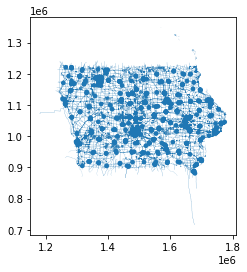

In [22]:
# plot scenario 1

scenario_1_union_df.plot() 

### 1.2b. Plot Residential Scenario 2 (10H)

<AxesSubplot:>

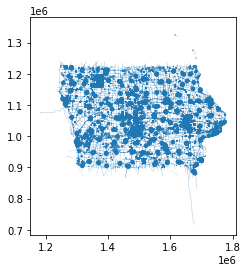

In [23]:
# plot scenario 2

scenario_2_union_df.plot() 

<a id='area'></a> 

## 2. Calculate Potential Wind ProductionSuitablility Area
For each wind data polyon, calculate the area (i.e., fraction of the polygon) suitable for wind production.

In [24]:
# read in wind_cells_10000 data
windcells_polygon = gpd.read_postgis('SELECT * FROM wind_cells_10000', con = db, geom_col = 'geom')

In [25]:
# windcells_polygon.head()

<AxesSubplot:>

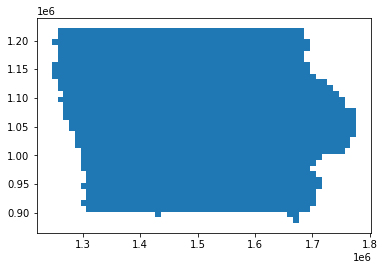

In [26]:
windcells_polygon.plot()

### 2.1 Plot Area Suitable for Wind Energy Production - Scenario 1 

In [27]:
# subtract scenario 1 from windcells using overlay

suitability_scenario_1 = windcells_polygon.overlay(scenario_1_union_df, how='difference')

/Applications/anaconda3/envs/eds223/lib/python3.8/site-packages/geopandas/geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 88 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<AxesSubplot:>

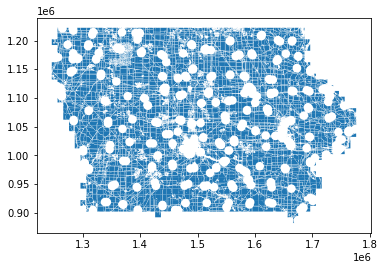

In [28]:
suitability_scenario_1.plot()

### 2.2 Plot Area Suitable for Wind Energy Production - Scenario 2 

In [29]:
# subtract scenario 2 from windcells using overlay

suitability_scenario_2 = windcells_polygon.overlay(scenario_2_union_df, how='difference')

<AxesSubplot:>

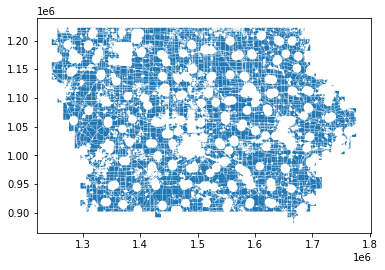

In [30]:
suitability_scenario_2.plot()

<a id='turbines'></a> 
## 3. Total Potential Wind Turbines
Calculate the number of wind turbines that could be placed in each polygon. Assume:
Vestas V136-3.45 MW turbines.
150 m hub height.
Turbine towers must be at least 5 rotor diameters apart.

In [31]:
# calculate minimum placement distance

turbine_footprint = math.pi * (d * 5) ** 2

### 3.1 Total Potential Wind Turbines - Secenario 1 (3H)

In [32]:
# calculate total area scenario 1

suitability_scenario_1['area_sq_m'] = suitability_scenario_1['geom'].area

In [33]:
# calculate number of turbines scenario 1

suitability_scenario_1['turbine_number'] = suitability_scenario_1['area_sq_m']/turbine_footprint

In [34]:
# check scenario 1 results
#suitability_scenario_1

In [35]:
turbine_1 = suitability_scenario_1['turbine_number'].sum()

In [36]:
turbine_1 = turbine_1.round(2)

### 3.2 Total Potential Wind Turbines - Secenario 2 (10H)

In [37]:
# calculate total area scenario 2

suitability_scenario_2['total_area'] = suitability_scenario_2['geom'].area

In [38]:
# calculate number of turbines scenario 2

suitability_scenario_2['turbine_number'] = suitability_scenario_2['total_area']/turbine_footprint

In [39]:
turbine_2 = suitability_scenario_2['turbine_number'].sum()

In [40]:
turbine_2 = turbine_2.round(2)

<a id='energy'></a> 

## 4. Total Wind Energy Production

Calculate the total potential energy production for Iowa.

### 4.1 Total Potential Wind Energy Production - Secenario 1 (3H)

In [41]:
# calculate annual energy production for scenario 1

suitability_scenario_1['annual_energy_production'] = (2.6 * suitability_scenario_1['wind_speed'] - 5) * suitability_scenario_1['turbine_number']

In [42]:
# sum annual energy production for scenario 1

power_production_1 = suitability_scenario_1['annual_energy_production'].sum()

In [43]:
# round annual energy production for scenario 1

power_production_1 = power_production_1.round(2)

### 4.2 Total Potential Wind Energy Production - Secenario 2 (10H)

In [44]:
# calculate annual energy production for scenario 2

suitability_scenario_2['annual_energy_production'] = (2.6 * suitability_scenario_2['wind_speed'] - 5) * suitability_scenario_2['turbine_number']

In [45]:
# sum annual energy production for scenario 2

power_production_2 = suitability_scenario_2['annual_energy_production'].sum()

In [46]:
# round annual energy production for scenario 2

power_production_2 = power_production_2.round(2)

<a id='results'></a> 

## 5. Results

In [47]:
print("The total number of turbines for residental scenario 1 was " + str(turbine_1))

The total number of turbines for residental scenario 1 was 57285.95


In [48]:
print("The total number of turbines for residental scenario 2 was " + str(turbine_2)) 

The total number of turbines for residental scenario 2 was 52053.23


In [51]:
print("The total energy produced under residential scenario 1 was " + str(power_production_1) + " GWh/y")

The total energy produced under residential scenario 1 was 1064159.97 GWh/y


In [52]:
print("The total energy produced under residential scenario 2 was " + str(power_production_2) + " GWh/y")

The total energy produced under residential scenario 2 was 966965.52 GWh/y


<a id='references'></a> 
## 6. References

Friends Against Wind. 2014. The 10H rule in Bavaria. Accessed 2021-11-26.

Sliz-Szkliniarz, B. (2019). Assessing the cost of onshore wind development scenarios_ Modelling of spatial and temporal distribution of wind power for the case of Poland. Renewable and Sustainable Energy Reviews, 18.

Wehrmann, B. 2019. Design of Germany's wind power distance rules undecided as opposition to policy grows. Clean Energy Wire. Accessed 2021-11-26.